## Step 1: Importing Libraries

In [ ]:
# Import necessary libraries for the project
import os
import cv2
import random
import pathlib

import numpy as np
import pandas as pd
import random as rn
import tensorflow as tf
import tensorflow_hub as hub

import plotly.subplots as sp
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from PIL import Image
from tensorflow import keras

from plotly.subplots import make_subplots
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG19, NASNetLarge, EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img



In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 99% 607M/612M [00:07<00:00, 52.3MB/s]
100% 612M/612M [00:07<00:00, 89.2MB/s]


In [ ]:
!unzip -q gtsrb-german-traffic-sign.zip

In [ ]:
metadf = pd.read_csv('data/Meta.csv')
traindf = pd.read_csv('data/Test.csv')
testdf = pd.read_csv('data/Train.csv')

In [ ]:
data_path= 'data/'
train_path = os.path.join(data_path, 'Train')
test_path = os.path.join(data_path, 'Test')
meta_path = os.path.join(data_path, 'Meta')

height = 50
width = 50

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons'
          }

In [ ]:
batch_size = 150
seed = 42

train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(height, width),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=seed,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
test_dataset = test_datagen.flow_from_directory(train_path,
                                                target_size=(height, width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


## Step 2: Visualizing Data/Results

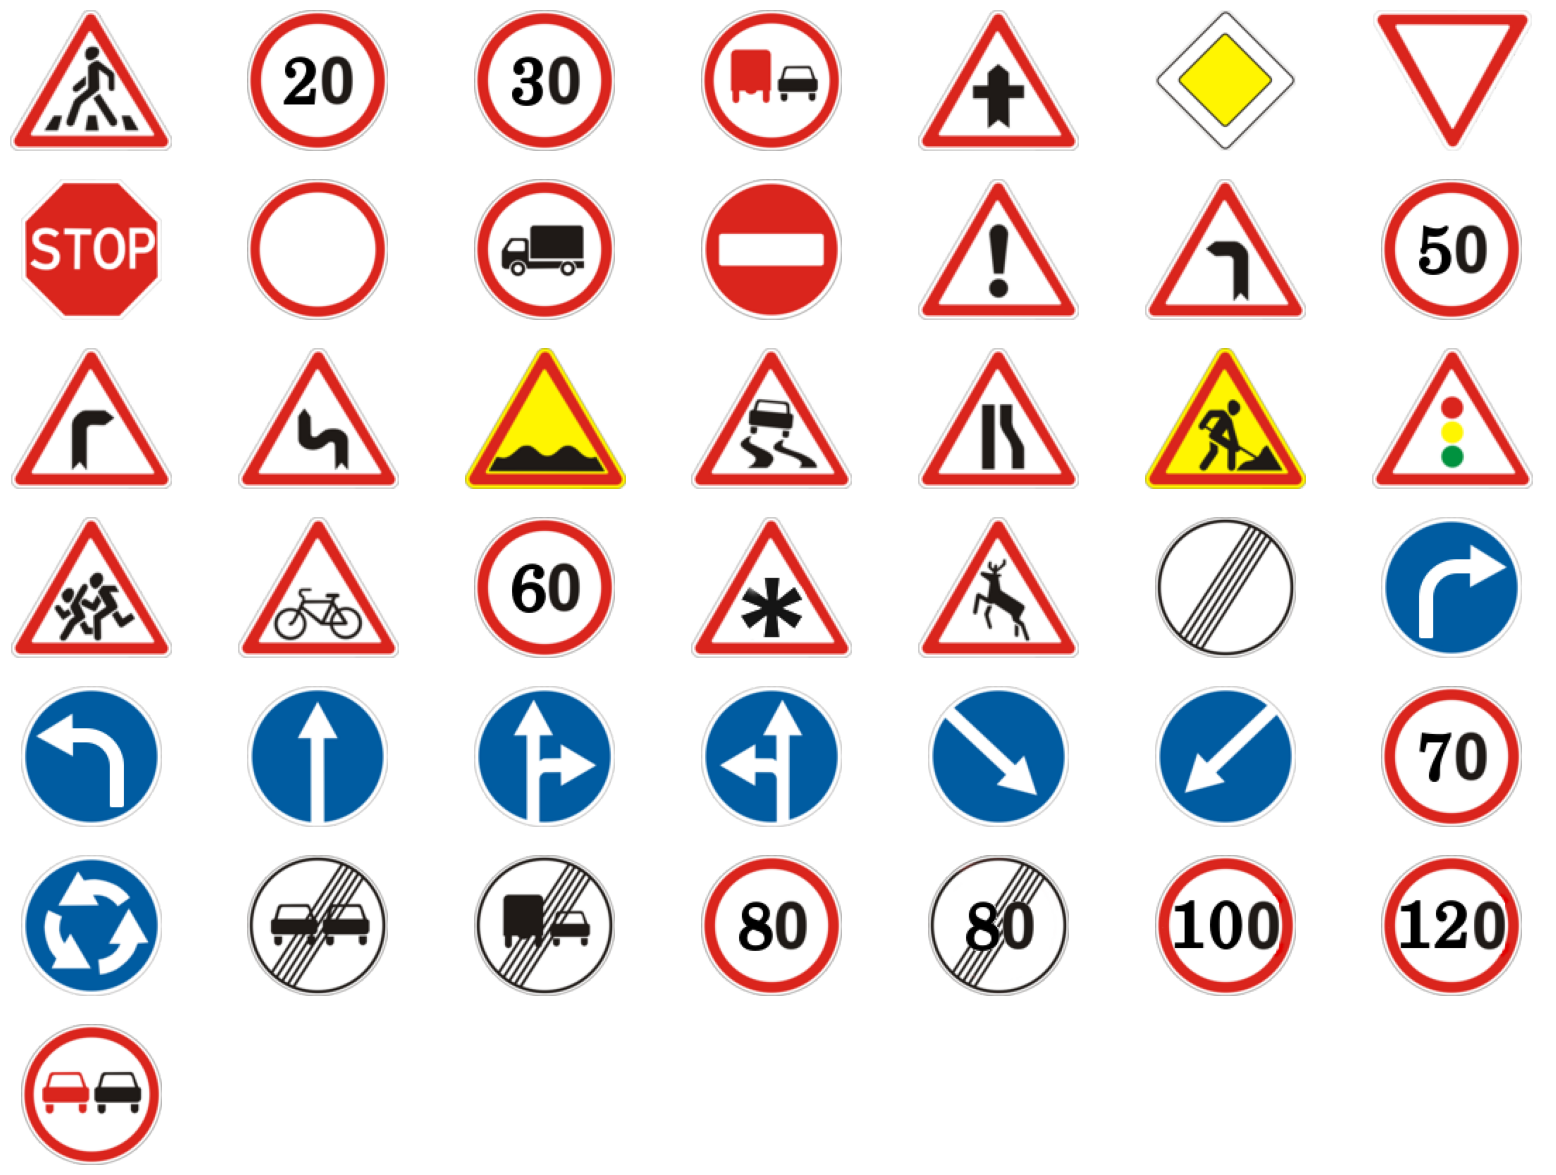

In [ ]:
# Display images and predictions
num_pictures = 43
num_rows = (num_pictures - 1) // 7 + 1
num_cols = min(num_pictures, 7)

signs = [os.path.join(data_path, metadf.Path.to_list()[i]) for i in range(num_pictures)]

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
for i, image_path in enumerate(signs):
    image = Image.open(image_path)
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(image)
    axes[row, col].axis('off')

# Remove any remaining empty subplots
for i in range(num_pictures, num_rows * num_cols):
    axes.flat[i].axis('off')

plt.show()

In [ ]:
classes = traindf["ClassId"].value_counts().head(43)

# Create a Plotly bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=classes.index,
    y=classes.values,
    marker_color='green'
))

fig.update_layout(
    title="Distribution of Class Labels in the dataset",
    xaxis_title="Classes",
    yaxis_title="Counts",
    xaxis=dict(type='category')
)

fig.show()

## Step 3: Creating the Model

In [ ]:
# Define the neural network architecture
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=(height,width,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.25),

    keras.layers.Dense(43, activation='softmax')
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 16)        1216      
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 32)        12832     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 21, 21, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 21, 21, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 19, 19, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 17, 17, 64)       

## Step 4: Compiling the Model

In [ ]:
# Prepare the model for training by setting the loss function, optimizer, and metrics
alpha=0.01
epochs=25
optim = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Step 5: Training the Model

In [ ]:
# Train the model on the training data
history = model.fit(train_dataset,
                    steps_per_epoch=len(train_dataset),
                    epochs=epochs,
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset))

Epoch 1/25
210/210 [==============================] - 373s 2s/step - loss: 0.5349 - accuracy: 0.8639 - val_loss: 1.0141 - val_accuracy: 0.7076
Epoch 2/25
210/210 [==============================] - 388s 2s/step - loss: 0.0552 - accuracy: 0.9832 - val_loss: 0.3893 - val_accuracy: 0.9038
Epoch 3/25
210/210 [==============================] - 382s 2s/step - loss: 0.0507 - accuracy: 0.9842 - val_loss: 0.4276 - val_accuracy: 0.8941
Epoch 4/25
210/210 [==============================] - 390s 2s/step - loss: 0.0258 - accuracy: 0.9922 - val_loss: 0.5073 - val_accuracy: 0.8995
Epoch 5/25
210/210 [==============================] - 416s 2s/step - loss: 0.0314 - accuracy: 0.9912 - val_loss: 0.6640 - val_accuracy: 0.8885
Epoch 6/25
210/210 [==============================] - 369s 2s/step - loss: 0.0526 - accuracy: 0.9852 - val_loss: 0.6434 - val_accuracy: 0.8544
Epoch 7/25
210/210 [==============================] - 363s 2s/step - loss: 0.0270 - accuracy: 0.9923 - val_loss: 0.3394 - val_accuracy: 0.9418

## Step 6: Visualizing Data/Results

In [ ]:
# Display images and predictions
# Create subplots with Plotly
fig = go.Figure()

# Plot Training and Validation Loss
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Validation Loss'))

# Customize layout for Loss plot
fig.update_layout(
    title='Model Loss',
    xaxis_title='Epochs',
    yaxis_title='Loss',
    yaxis_range=[0, 1],
    legend=dict(x=0.7, y=1.1),
)

# Create another subplot for Accuracy
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['accuracy'], mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))

# Customize layout for Accuracy plot
fig.update_layout(
    title='Model Accuracy',
    xaxis_title='Epochs',
    yaxis_title='Accuracy',
    yaxis_range=[0.5, 1],
)

# Adjust the subplot positioning and size
fig.update_layout(height=600, width=800, showlegend=True)

# Add a title for the entire figure
fig.update_layout(title_text='Custom CNN Performance')

# Show the figure
fig.show()

In [ ]:
model.save("SIGNSIDF.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
data_dir = 'data/'

def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]

test_labels = testdf["ClassId"].values
imgs = testdf["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((height, width))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)

X_test = np.array(data)
X_test = X_test/255

## Step 7: Testing the model

In [ ]:
# Import necessary libraries for the project
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))

# Calculate the accuracy
test_accuracy = accuracy_score(test_labels, pred) * 100

# Print the test data accuracy with two digits after the decimal point and the percent symbol
print('Test Data accuracy: {:.2f}%'.format(test_accuracy))

1226/1226 [==============================] - 115s 93ms/step
Test Data accuracy: 97.58%
